# Find the best neighborhood in Madrid to open a Restaurant

### 1. Introduction
  


Madrid is the capital and the most populated city in Spain. The city has almost 3.3 million inhabitants and a metropolitan area population of approximately 6.5 million. It concentrates activities directly related to power and to knowledge and technological innovation. It is one of the largest financial centers in Europe and the largest in Spain.

  * **Bussines Poblem**
  
Madrid is administratively divided into 21 districts, which in turn are subdivided into 131 neighborhoods. 

Are there differences from one district to another? How are businesses distributed in each of your districts? Where would it be more prosperous to open a new restaurant?

In this analysis we will try to find an optimal location for a restaurant in Madrid taking into account the competitors and which group of people with income will be attracted according to the population of the neighborhood. To do this we will use an unsupervised automatic learning algorithm (K-Means) and will take into account demographic data, per capita income by district and housing prices.


### 2. Data acquisition

Based on the definition of our problem. The necessary data sources have been obtained from:

- **Foursquare API**: Collection of restaurant related data (location, distribution, type of food)

- **National Institute of Statistics (INE)**: Official site for downloading demographic data, per capita income and housing prices.

- **Madrid City Council open data portal**: Official site for downloading data related to Madrid.

### 3. Methodology


#### Importing the necessary libraries

In [161]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

import requests # library to handle requests

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data standarization
from sklearn.preprocessing import MinMaxScaler # Data standarization

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


#### Exploring data

In [162]:
# Boroughs and Neighborhoods from Madrid
df = pd.read_csv('barrios_municipio_madrid.csv',sep= ';', encoding='Latin 1')
df.head()

,barrio_codigo,barrio_nombre,distrito_codigo,distrito_nombre,municipio_codigo,municipio_nombre,superficie_km2,densidad_por_km2
0,796011,Palacio,79601,Centro,796,Madrid,1.46,15323.29
1,796012,Embajadores,79601,Centro,796,Madrid,1.03,43345.63
2,796013,Cortes,79601,Centro,796,Madrid,0.59,17850.85
3,796014,Justicia,79601,Centro,796,Madrid,0.75,21866.67
4,796015,Universidad,79601,Centro,796,Madrid,0.93,33051.61


In [163]:
df.columns

Index(['barrio_codigo', 'barrio_nombre', 'distrito_codigo', 'distrito_nombre',
       'municipio_codigo', 'municipio_nombre', 'superficie_km2',
       'densidad_por_km2'],
      dtype='object')

In [164]:
df.shape

(128, 8)

In [165]:
# Extracting the necessary columns 
dfm=df.groupby(['distrito_codigo','distrito_nombre']).agg(','.join)
dfm.reset_index(inplace=True)
dfm.drop(['municipio_nombre'], axis=1, inplace=True)
dfm

,distrito_codigo,distrito_nombre,barrio_nombre
0,79601,Centro,"Palacio, Embajadores, Co..."
1,79602,Arganzuela,"Imperial, Las Acacias, L..."
2,79603,Retiro,"Pacífico, Adelfas, Estre..."
3,79604,Salamanca,"Recoletos, Goya, Fuente ..."
4,79605,Chamartín,"El Viso, Prosperidad, Ci..."
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ..."
6,79607,Chamberí,"Gaztambide, Arapiles, Tr..."
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ..."
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ..."
9,79610,Latina,"Los Cármenes, Puerta del Angel,..."


In [166]:
dfm.shape

(21, 3)

In [167]:
# Population by borough
df2 = pd.read_csv('poblacion_distritos.csv',sep= ';')
df2.head()

,Distrito,Superficie (Ha),Densidad (hab./Ha),Población a 1-1-2020
0,Centro,"522,82","268,68",140.473
1,Arganzuela,"646,22",241,155.660
2,Retiro,"546,62",220,120.406
3,Salamanca,"539,24",274,147.854
4,Chamartín,"917,55",161,147.551


In [168]:
# Per capita income  and housing prices by borough
pv=pd.read_excel('precio_vivienda.xls', sheet_name=0)
pv

,Distrito,Nov_20,Oct_20,Sep_20,Ago_20,Jul_20,Jun_20,May_20,Abr_20,Mar_20,...,Sep_19,Ago_19,Jul_19,Jun_19,May_19,Abr_19,Mar_19,Feb_19,Ene_19,Renta_INE
0,Centro,4878,4909,4934,4963,4981,5061,5075,5062,5026,...,4994,4993,5044,5031,4991,5034,5069,5033,4987,16147
1,Arganzuela,3917,3908,3915,3912,3910,3948,3962,3903,3878,...,4059,4073,4096,4085,4080,4095,4071,4042,4017,17306
2,Retiro,3917,3908,3915,3912,4513,4564,4586,4560,4555,...,4572,4575,4598,4660,4669,4637,4631,4614,4529,21504
3,Salamanca,4520,5808,5826,5833,5903,5986,3962,3903,4555,...,5788,5791,5860,5868,5848,5850,5818,5829,5752,24433
4,Chamartín,5018,5040,5056,5068,5109,5180,5179,5143,5118,...,4980,4931,4941,4934,5051,5102,5174,5196,5187,25969
5,Tetuán,5018,5040,5056,3669,3682,3696,3679,3714,3725,...,3716,3719,3702,3719,3722,3731,3725,3693,3644,14970
6,Chamberí,5288,5334,5374,5329,5337,5419,5432,5426,5386,...,5331,5347,5309,5271,5287,5276,5249,5253,5285,22499
7,Fuencarral-El Pardo,3917,3908,3915,3912,4513,5986,3573,3570,3530,...,3480,3447,3436,3369,3402,3418,3379,3364,3374,18573
8,Moncloa-Aravaca,3893,3877,3913,3905,3910,3913,3898,3932,3939,...,3896,3910,3931,3928,3950,3905,3892,3875,3854,22152
9,Latina,2246,2246,2254,2269,2310,2330,2330,2364,2341,...,2292,2293,2276,2292,2290,2291,2280,2305,2303,12232


In [169]:
pv['AvgHousingPrice']=pv.mean(axis=1)
pv

,Distrito,Nov_20,Oct_20,Sep_20,Ago_20,Jul_20,Jun_20,May_20,Abr_20,Mar_20,...,Ago_19,Jul_19,Jun_19,May_19,Abr_19,Mar_19,Feb_19,Ene_19,Renta_INE,AvgHousingPrice
0,Centro,4878,4909,4934,4963,4981,5061,5075,5062,5026,...,4993,5044,5031,4991,5034,5069,5033,4987,16147,5479.500000
1,Arganzuela,3917,3908,3915,3912,3910,3948,3962,3903,3878,...,4073,4096,4085,4080,4095,4071,4042,4017,17306,4547.750000
2,Retiro,3917,3908,3915,3912,4513,4564,4586,4560,4555,...,4575,4598,4660,4669,4637,4631,4614,4529,21504,5178.416667
3,Salamanca,4520,5808,5826,5833,5903,5986,3962,3903,4555,...,5791,5860,5868,5848,5850,5818,5829,5752,24433,6352.916667
4,Chamartín,5018,5040,5056,5068,5109,5180,5179,5143,5118,...,4931,4941,4934,5051,5102,5174,5196,5187,25969,5944.666667
5,Tetuán,5018,5040,5056,3669,3682,3696,3679,3714,3725,...,3719,3702,3719,3722,3731,3725,3693,3644,14970,4333.708333
6,Chamberí,5288,5334,5374,5329,5337,5419,5432,5426,5386,...,5347,5309,5271,5287,5276,5249,5253,5285,22499,6040.750000
7,Fuencarral-El Pardo,3917,3908,3915,3912,4513,5986,3573,3570,3530,...,3447,3436,3369,3402,3418,3379,3364,3374,18573,4322.333333
8,Moncloa-Aravaca,3893,3877,3913,3905,3910,3913,3898,3932,3939,...,3910,3931,3928,3950,3905,3892,3875,3854,22152,4676.958333
9,Latina,2246,2246,2254,2269,2310,2330,2330,2364,2341,...,2293,2276,2292,2290,2291,2280,2305,2303,12232,2711.583333


In [170]:
pv.columns

Index(['Distrito', 'Nov_20', 'Oct_20', 'Sep_20', 'Ago_20', 'Jul_20', 'Jun_20',
       'May_20', 'Abr_20', 'Mar_20', 'Feb_20', 'Ene_20', 'Unnamed: 12',
       'Dic_19', 'Nov_19', 'Oct_19', 'Sep_19', 'Ago_19', 'Jul_19', 'Jun_19',
       'May_19', 'Abr_19', 'Mar_19', 'Feb_19', 'Ene_19', 'Renta_INE',
       'AvgHousingPrice'],
      dtype='object')

In [171]:
renta=pv[['Distrito','Renta_INE','AvgHousingPrice']]
renta

,Distrito,Renta_INE,AvgHousingPrice
0,Centro,16147,5479.500000
1,Arganzuela,17306,4547.750000
2,Retiro,21504,5178.416667
3,Salamanca,24433,6352.916667
4,Chamartín,25969,5944.666667
5,Tetuán,14970,4333.708333
6,Chamberí,22499,6040.750000
7,Fuencarral-El Pardo,18573,4322.333333
8,Moncloa-Aravaca,22152,4676.958333
9,Latina,12232,2711.583333


In [172]:
# Formato poblacion
#df2.style.format("{:.2f}")

In [173]:
# Merging in a single dataset
md = dfm.join(df2['Población a 1-1-2020'])
md

,distrito_codigo,distrito_nombre,barrio_nombre,Población a 1-1-2020
0,79601,Centro,"Palacio, Embajadores, Co...",140.473
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139


In [174]:
md2 = md.join(renta)
md2.drop('Distrito', axis=1, inplace=True)
md2

,distrito_codigo,distrito_nombre,barrio_nombre,Población a 1-1-2020,Renta_INE,AvgHousingPrice
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333


In [175]:
md2.shape

(21, 6)

In [176]:
# Renaming the columns
md2.rename(columns={'distrito_codigo': 'Postcode', 'distrito_nombre':'Borough','barrio_nombre':'Neighborhood','Población a 1-1-2020':'Population', 'Renta_INE':'RentaINE'}, inplace=True)
md2

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333


In [177]:
md3=md2.loc[:,['Borough','Population']]
md3.to_csv('madrid.csv')

In [178]:
md2.describe()

,Postcode,Population,RentaINE,AvgHousingPrice
count,21.000000,21.000000,21.000000,21.000000
mean,79611.000000,158.796667,16078.428571,3882.521825
std,6.204837,57.538604,5046.096229,1364.257435
min,79601.000000,50.010000,9395.000000,2049.583333
25%,79606.000000,121.683000,11925.000000,2702.416667
50%,79611.000000,147.854000,15408.000000,3770.916667
75%,79616.000000,193.264000,18573.000000,4676.958333
max,79621.000000,260.196000,25969.000000,6352.916667


In [179]:
#Visualizing 

In [180]:
data = md2.groupby('Borough')['Population'].sum()

In [181]:
data_per = data.groupby('Borough').agg(percentage =('Population', lambda p: p.sum() / data.sum() * 100)).round(2)

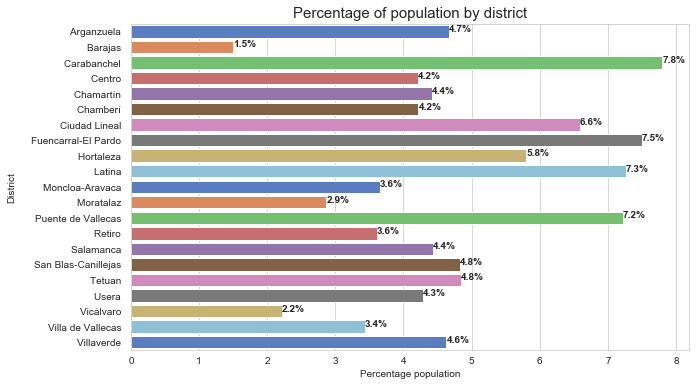

In [182]:

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per.index, data=data_per, ci=None, palette="muted",orient='h' )
ax.set_title("Percentage of population by district", fontsize=15)
ax.set_xlabel ("Percentage population")
ax.set_ylabel ("District")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
bar.savefig("Seaborn_Bar_Vertical.png");

In [183]:
data2 = md2.groupby('Borough')['RentaINE'].sum()
data_per2 = data2.groupby('Borough').agg(percentage =('RentaINE', lambda p: p.sum() / data2.sum() * 100)).round(2)

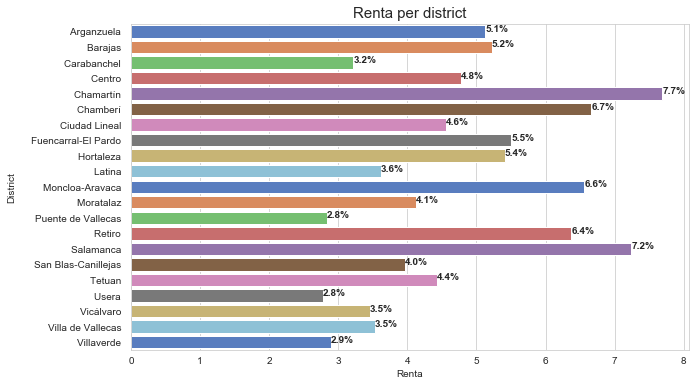

In [184]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per2.index, data=data_per2, ci=None, palette="muted",orient='h' )
ax.set_title("Renta per district", fontsize=15)
ax.set_xlabel ("Renta")
ax.set_ylabel ("District")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

In [185]:
data3 = md2.groupby('Borough')['AvgHousingPrice'].sum()
data_per3 = data3.groupby('Borough').agg(percentage =('AvgHousingPrice', lambda p: p.sum() / data3.sum() * 100)).round(2)

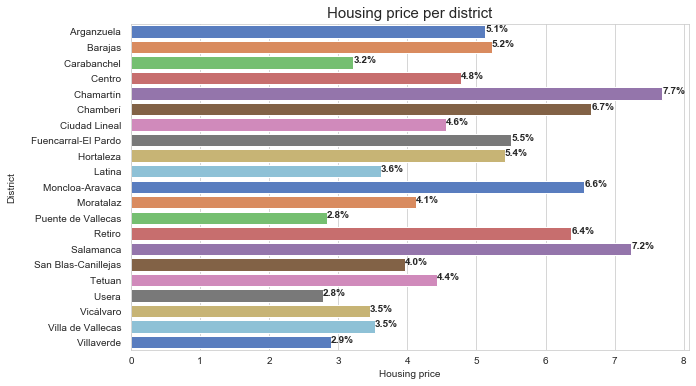

In [186]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per3.index, data=data_per2, ci=None, palette="muted",orient='h' )
ax.set_title("Housing price per district", fontsize=15)
ax.set_xlabel ("Housing price")
ax.set_ylabel ("District")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

In [187]:
# Getting latitude and longitude data for each borough in a new dataset
dist_name= md2['Borough'].tolist()
columns=['Borough','Latitude','Longitude']
columns

['Borough', 'Latitude', 'Longitude']

In [188]:
dist_name= md2['Borough'].tolist()
columns=['Borough','Latitude','Longitude']
lat_lng=pd.DataFrame(columns=columns)
for borough in dist_name:
    locator=Nominatim(user_agent= 'init')
    location=locator.geocode('{}, Madrid, Spain'.format(borough))
    lat=location.latitude
    lng=location.longitude
    print('Borough = {}, Latitude = {}, Longitude = {}'.format(borough,location.latitude, location.longitude))
    lat_lng=lat_lng.append({'Borough': borough, 'Latitude': lat,'Longitude':lng},ignore_index=True)
lat_lng    

Borough =     Centro , Latitude = 40.417652700000005, Longitude = -3.7079137662915533
Borough =     Arganzuela , Latitude = 40.39806845, Longitude = -3.6937339526567428
Borough =     Retiro , Latitude = 40.4111495, Longitude = -3.6760566
Borough =     Salamanca , Latitude = 40.4270451, Longitude = -3.6806024
Borough =     Chamartín , Latitude = 40.4589872, Longitude = -3.6761288
Borough =     Tetuan , Latitude = 40.4605781, Longitude = -3.6982806
Borough =     Chamberí , Latitude = 40.43624735, Longitude = -3.7038303534513837
Borough =     Fuencarral-El Pardo , Latitude = 40.55634555, Longitude = -3.7785905137518054
Borough =     Moncloa-Aravaca , Latitude = 40.43949485, Longitude = -3.7442035396547055
Borough =     Latina , Latitude = 40.4035317, Longitude = -3.736152
Borough =     Carabanchel , Latitude = 40.3742112, Longitude = -3.744676
Borough =     Usera , Latitude = 40.383894, Longitude = -3.7064459
Borough =     Puente de Vallecas , Latitude = 40.3835532, Longitude = -3.6545354

,Borough,Latitude,Longitude
0,Centro,40.417653,-3.707914
1,Arganzuela,40.398068,-3.693734
2,Retiro,40.411150,-3.676057
3,Salamanca,40.427045,-3.680602
4,Chamartín,40.458987,-3.676129
5,Tetuan,40.460578,-3.698281
6,Chamberí,40.436247,-3.703830
7,Fuencarral-El Pardo,40.556346,-3.778591
8,Moncloa-Aravaca,40.439495,-3.744204
9,Latina,40.403532,-3.736152


In [189]:
mon=locator.geocode('parque del oeste,Madrid,Spain')
print((mon.latitude, mon.longitude))

(40.429696050000004, -3.7251884447637913)


In [190]:
lat_lng .iloc[8,0]

'    Moncloa-Aravaca '

In [191]:
lat_lng .iloc[8,1]=40.429696050000004

In [192]:
lat_lng .iloc[8,2]=-3.7251884447637913

In [193]:
pil=locator.geocode('Pilar,Madrid,Spain')
print((pil.latitude, pil.longitude))

(40.4771334, -3.7089157)


In [194]:
lat_lng .iloc[7,0]

'    Fuencarral-El Pardo '

In [195]:
lat_lng .iloc[7,1]=40.4771334

In [196]:
lat_lng .iloc[7,2]=-3.7035825

In [197]:
lat_lng.info

<bound method DataFrame.info of                      Borough   Latitude  Longitude
0                    Centro   40.417653  -3.707914
1                Arganzuela   40.398068  -3.693734
2                    Retiro   40.411150  -3.676057
3                 Salamanca   40.427045  -3.680602
4                 Chamartín   40.458987  -3.676129
5                    Tetuan   40.460578  -3.698281
6                  Chamberí   40.436247  -3.703830
7       Fuencarral-El Pardo   40.477133  -3.703582
8           Moncloa-Aravaca   40.429696  -3.725188
9                    Latina   40.403532  -3.736152
10              Carabanchel   40.374211  -3.744676
11                    Usera   40.383894  -3.706446
12       Puente de Vallecas   40.383553  -3.654535
13                Moratalaz   40.405933  -3.644874
14            Ciudad Lineal   40.448431  -3.650495
15                Hortaleza   40.472549  -3.642552
16               Villaverde   40.345610  -3.695956
17        Villa de Vallecas   40.373958  -3.612163

In [198]:
# Merging in a single dataset
madrid_data=pd.merge(md2,lat_lng, on='Borough')
madrid_data

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000,40.417653,-3.707914
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000,40.398068,-3.693734
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667,40.411150,-3.676057
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667,40.427045,-3.680602
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667,40.458987,-3.676129
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333,40.460578,-3.698281
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000,40.436247,-3.703830
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333,40.477133,-3.703582
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333,40.429696,-3.725188
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333,40.403532,-3.736152


##### Plotting all Borough

In [199]:
mad=locator.geocode('Madrid, Spain')
print((mad.latitude, mad.longitude))

(40.4167047, -3.7035825)


In [200]:
map_madrid = folium.Map(location=[40.4167047, -3.7035825], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(madrid_data['Latitude'], madrid_data['Longitude'], madrid_data['Borough'], madrid_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

#### Using the Foursquare API to explore the bussines in each borough.

In [201]:
CLIENT_ID = 'UJSBYU5XYYBJNVVOAWZWRJ02ADL02UZDOWETIWSGQRRVEZ0L' # your Foursquare ID
CLIENT_SECRET = 'EVM4ZA4V3QCH0WJTSLKX45POE5LLLOO5WCVSOMSIVSGXT5NS' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 200

In [202]:
venue_category = '4d4b7105d754a06374d81259' #Food Category Id
radius = 2000
def getNearbyVenues(names, latitudes, longitudes, radius=radius):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            venue_category,    
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            300)

        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    food_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    food_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
        
    return(food_venues)

In [203]:
madrid_venues = getNearbyVenues(names=madrid_data['Borough'],
                                   latitudes=madrid_data['Latitude'],
                                   longitudes=madrid_data['Longitude']
                                  )

In [204]:
madrid_venues.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.417653,-3.707914,Chocolatería San Ginés,40.416754,-3.707079,Chocolate Shop
1,Centro,40.417653,-3.707914,Churrería Los Artesanos 1902,40.417581,-3.707029,Coffee Shop
2,Centro,40.417653,-3.707914,Five Guys,40.420526,-3.705540,Burger Joint
3,Centro,40.417653,-3.707914,Rosi La Loca,40.415821,-3.702955,Tapas Restaurant
4,Centro,40.417653,-3.707914,Gourmet Experience,40.419667,-3.705458,Gourmet Shop


In [205]:
madrid_venues.shape

(1001, 7)

In [206]:
madrid_venues.groupby('Borough')['Venue','Venue Category'].count()

,Venue,Venue Category
Borough,,
Arganzuela,50,50
Barajas,49,49
Carabanchel,50,50
Centro,50,50
Chamartín,50,50
Chamberí,50,50
Ciudad Lineal,50,50
Fuencarral-El Pardo,50,50
Hortaleza,50,50


In [207]:
print('There are {} uniques categories.'.format(len(madrid_venues['Venue Category'].unique())))

There are 87 uniques categories.


In [208]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="",prefix_sep="")
#remove the column Neighborhood
#madrid_onehot.drop(['Neighborhood'],axis=1,inplace=True)

#add the column Neighborhood in position 0 with the same values as madrid_rest
madrid_onehot.insert(loc=0, column='Borough', value=madrid_venues['Borough'] )

madrid_onehot.head()

,Borough,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Garden,Bistro,Bookstore,...,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar
0,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Centro,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [209]:
madrid_onehot.shape

(1001, 88)

In [210]:
# Grouping hot encoding matrix by borough
madrid_grouped = madrid_onehot.groupby('Borough').mean().reset_index()
madrid_grouped

,Borough,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Garden,Bistro,Bookstore,...,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar
0,Arganzuela,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.00,0.000000,0.00,...,0.000000,0.00,0.080000,0.00,0.000000,0.000000,0.00,0.000000,0.02,0.00
1,Barajas,0.000000,0.020408,0.000000,0.000000,0.061224,0.000000,0.00,0.040816,0.00,...,0.000000,0.00,0.020408,0.00,0.000000,0.000000,0.00,0.020408,0.00,0.00
2,Carabanchel,0.020000,0.000000,0.040000,0.040000,0.100000,0.020000,0.00,0.000000,0.00,...,0.000000,0.02,0.040000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00
3,Centro,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.00,0.000000,0.00,...,0.000000,0.00,0.060000,0.00,0.000000,0.000000,0.02,0.000000,0.00,0.00
4,Chamartín,0.020000,0.020000,0.020000,0.000000,0.080000,0.000000,0.00,0.020000,0.00,...,0.000000,0.00,0.040000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00
5,Chamberí,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,0.00,0.000000,0.00,...,0.000000,0.00,0.080000,0.00,0.000000,0.000000,0.04,0.000000,0.00,0.00
6,Ciudad Lineal,0.020000,0.040000,0.040000,0.000000,0.060000,0.020000,0.00,0.000000,0.00,...,0.020000,0.00,0.100000,0.02,0.000000,0.000000,0.00,0.000000,0.00,0.02
7,Fuencarral-El Pardo,0.040000,0.020000,0.020000,0.000000,0.080000,0.020000,0.00,0.000000,0.00,...,0.000000,0.00,0.060000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00
8,Hortaleza,0.040000,0.040000,0.040000,0.000000,0.100000,0.000000,0.00,0.000000,0.00,...,0.000000,0.00,0.060000,0.02,0.000000,0.000000,0.00,0.000000,0.00,0.00
9,Latina,0.000000,0.000000,0.020000,0.000000,0.060000,0.000000,0.00,0.000000,0.00,...,0.000000,0.00,0.020000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.02


In [248]:
# Adding Population, RentaINE and AvgHousingPrice data
md3=madrid_data[['Borough','Population','RentaINE','AvgHousingPrice']]
madrid_total=pd.merge(md3,madrid_grouped, on='Borough')

In [249]:
madrid_total

,Borough,Population,RentaINE,AvgHousingPrice,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,...,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar
0,Centro,140.473,16147,5479.500000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,...,0.000000,0.00,0.060000,0.00,0.000000,0.000000,0.02,0.000000,0.00,0.00
1,Arganzuela,155.660,17306,4547.750000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,...,0.000000,0.00,0.080000,0.00,0.000000,0.000000,0.00,0.000000,0.02,0.00
2,Retiro,120.406,21504,5178.416667,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,...,0.000000,0.00,0.100000,0.00,0.000000,0.000000,0.00,0.000000,0.02,0.00
3,Salamanca,147.854,24433,6352.916667,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,...,0.000000,0.00,0.120000,0.00,0.000000,0.000000,0.02,0.000000,0.00,0.00
4,Chamartín,147.551,25969,5944.666667,0.020000,0.020000,0.020000,0.000000,0.080000,0.000000,...,0.000000,0.00,0.040000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00
5,Tetuan,161.313,14970,4333.708333,0.020000,0.000000,0.020000,0.000000,0.060000,0.020000,...,0.000000,0.00,0.080000,0.00,0.000000,0.000000,0.02,0.000000,0.00,0.00
6,Chamberí,140.866,22499,6040.750000,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,...,0.000000,0.00,0.080000,0.00,0.000000,0.000000,0.04,0.000000,0.00,0.00
7,Fuencarral-El Pardo,249.973,18573,4322.333333,0.040000,0.020000,0.020000,0.000000,0.080000,0.020000,...,0.000000,0.00,0.060000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00
8,Moncloa-Aravaca,121.683,22152,4676.958333,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.000000,0.00,0.060000,0.00,0.000000,0.000000,0.06,0.000000,0.00,0.00
9,Latina,242.139,12232,2711.583333,0.000000,0.000000,0.020000,0.000000,0.060000,0.000000,...,0.000000,0.00,0.020000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.02


In [250]:
#Transforming the dataset (madrid_total) by scaling each feature 
X = MinMaxScaler().fit_transform(madrid_total.iloc[:,1:])
X

array([[0.43039498, 0.40738506, 0.79703718, ..., 0.        , 0.        ,
        0.        ],
       [0.50265003, 0.47731387, 0.58051898, ..., 0.        , 1.        ,
        0.        ],
       [0.3349224 , 0.73060215, 0.72707204, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.11436537, 0.13877157, 0.14703718, ..., 0.        , 0.        ,
        0.        ],
       [0.52911231, 0.24188488, 0.21381681, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.49752625, 0.4       , ..., 1.        , 0.        ,
        0.        ]])

In [251]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [252]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = madrid_grouped['Borough']

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arganzuela,Coffee Shop,Restaurant,Bakery,Tapas Restaurant,Café,Spanish Restaurant,Grocery Store,Japanese Restaurant,Cafeteria,Pie Shop
1,Barajas,Spanish Restaurant,Coffee Shop,Restaurant,Fast Food Restaurant,Bakery,Café,Mexican Restaurant,Sandwich Place,Bistro,Snack Place
2,Carabanchel,Restaurant,Bakery,Spanish Restaurant,Fast Food Restaurant,Café,BBQ Joint,Asian Restaurant,Tapas Restaurant,Gastropub,Snack Place
3,Centro,Coffee Shop,Spanish Restaurant,Bakery,Restaurant,Tapas Restaurant,Dessert Shop,Market,Mediterranean Restaurant,Modern European Restaurant,Café
4,Chamartín,Spanish Restaurant,Restaurant,Coffee Shop,Bakery,Burger Joint,Japanese Restaurant,Tapas Restaurant,Salad Place,Fast Food Restaurant,Gym


In [253]:
# set number of clusters
kclusters = 4
#madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 3, 3, 0, 3, 0, 1], dtype=int32)

In [254]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

madrid_merged = madrid_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
madrid_merged = madrid_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')

madrid_merged.head(20)

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000,40.417653,-3.707914,0,Coffee Shop,Spanish Restaurant,Bakery,Restaurant,Tapas Restaurant,Dessert Shop,Market,Mediterranean Restaurant,Modern European Restaurant,Café
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000,40.398068,-3.693734,0,Coffee Shop,Restaurant,Bakery,Tapas Restaurant,Café,Spanish Restaurant,Grocery Store,Japanese Restaurant,Cafeteria,Pie Shop
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667,40.411150,-3.676057,2,Coffee Shop,Restaurant,Spanish Restaurant,Tapas Restaurant,Bakery,Market,Grocery Store,Café,Italian Restaurant,Seafood Restaurant
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667,40.427045,-3.680602,3,Coffee Shop,Restaurant,Spanish Restaurant,Tapas Restaurant,Bakery,Dessert Shop,Breakfast Spot,Italian Restaurant,Diner,Mediterranean Restaurant
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667,40.458987,-3.676129,3,Spanish Restaurant,Restaurant,Coffee Shop,Bakery,Burger Joint,Japanese Restaurant,Tapas Restaurant,Salad Place,Fast Food Restaurant,Gym
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333,40.460578,-3.698281,1,Spanish Restaurant,Restaurant,Coffee Shop,Tapas Restaurant,Bakery,Burger Joint,Seafood Restaurant,Café,Fast Food Restaurant,Dessert Shop
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000,40.436247,-3.703830,3,Coffee Shop,Spanish Restaurant,Restaurant,Tapas Restaurant,Bakery,Vegetarian / Vegan Restaurant,Gourmet Shop,Café,Diner,Chocolate Shop
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333,40.477133,-3.703582,3,Spanish Restaurant,Restaurant,Coffee Shop,Bakery,Café,Tapas Restaurant,Burger Joint,American Restaurant,Kebab Restaurant,Seafood Restaurant
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333,40.429696,-3.725188,2,Coffee Shop,Restaurant,Spanish Restaurant,Mexican Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Café,Diner,Bakery,Gourmet Shop
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333,40.403532,-3.736152,1,Spanish Restaurant,Coffee Shop,Restaurant,Bakery,Sandwich Place,Café,Brewery,Burger Joint,Diner,Peruvian Restaurant


#### Creating the map of all the restaurants along with their cuisine specialities and plotting all the companies on the same map for evaluation purpose. The clusters in the map shows different types of restaurants on the basis of different attributes, mainly cuisine.

In [255]:

# create map
map_clusters = folium.Map(location=[40.4167047, -3.7035825], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Latitude'], madrid_merged['Longitude'], madrid_merged['Neighborhood'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining Clusters

In [256]:
madrid_merged[madrid_merged['Cluster Labels']== 0].sort_values('Borough')

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000,40.398068,-3.693734,0,Coffee Shop,Restaurant,Bakery,Tapas Restaurant,Café,Spanish Restaurant,Grocery Store,Japanese Restaurant,Cafeteria,Pie Shop
20,79621,Barajas,"Alameda de Osuna, Aeropuerto, ...",50.010,17641,3770.916667,40.473318,-3.579845,0,Spanish Restaurant,Coffee Shop,Restaurant,Fast Food Restaurant,Bakery,Café,Mexican Restaurant,Sandwich Place,Bistro,Snack Place
10,79611,Carabanchel,"Comillas, Opañel, San Is...",260.196,10872,2537.500000,40.374211,-3.744676,0,Restaurant,Bakery,Spanish Restaurant,Fast Food Restaurant,Café,BBQ Joint,Asian Restaurant,Tapas Restaurant,Gastropub,Snack Place
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000,40.417653,-3.707914,0,Coffee Shop,Spanish Restaurant,Bakery,Restaurant,Tapas Restaurant,Dessert Shop,Market,Mediterranean Restaurant,Modern European Restaurant,Café
14,79615,Ciudad Lineal,"Ventas, Pueblo Nuevo, Qu...",219.867,15408,3539.333333,40.448431,-3.650495,0,Spanish Restaurant,Restaurant,Tapas Restaurant,Coffee Shop,Fast Food Restaurant,Bakery,Burger Joint,Café,Chinese Restaurant,Pizza Place
15,79616,Hortaleza,"Palomas, Piovera, Canill...",193.264,18277,4218.958333,40.472549,-3.642552,0,Bakery,Spanish Restaurant,Restaurant,Chinese Restaurant,Mediterranean Restaurant,Tapas Restaurant,American Restaurant,Breakfast Spot,Café,Burger Joint


In [257]:
madrid_merged[madrid_merged['Cluster Labels']== 1].sort_values('Borough')

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333,40.403532,-3.736152,1,Spanish Restaurant,Coffee Shop,Restaurant,Bakery,Sandwich Place,Café,Brewery,Burger Joint,Diner,Peruvian Restaurant
13,79614,Moratalaz,"Pavones, Horcajo, Marroq...",95.614,13944,2900.000000,40.405933,-3.644874,1,Coffee Shop,Spanish Restaurant,Café,Tapas Restaurant,Chinese Restaurant,Bakery,Peruvian Restaurant,Bar,Restaurant,Italian Restaurant
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333,40.460578,-3.698281,1,Spanish Restaurant,Restaurant,Coffee Shop,Tapas Restaurant,Bakery,Burger Joint,Seafood Restaurant,Café,Fast Food Restaurant,Dessert Shop
18,79619,Vicálvaro,"Casco Histórico de Vicálvaro, A...",74.048,11695,2682.333333,40.396584,-3.576622,1,Café,Spanish Restaurant,Pizza Place,Bakery,Diner,Mediterranean Restaurant,Farmers Market,Cupcake Shop,Deli / Bodega,Dessert Shop
16,79617,Villaverde,"San Andrés, San Cristobal, ...",154.318,9756,2049.583333,40.345610,-3.695956,1,Spanish Restaurant,Restaurant,Bakery,Coffee Shop,Tapas Restaurant,Burger Joint,Mediterranean Restaurant,Turkish Restaurant,Pizza Place,Café


In [258]:
madrid_merged[madrid_merged['Cluster Labels']== 2].sort_values('Borough')

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333,40.429696,-3.725188,2,Coffee Shop,Restaurant,Spanish Restaurant,Mexican Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Café,Diner,Bakery,Gourmet Shop
12,79613,Puente de Vallecas,"Entrevías, San Diego, Pa...",240.867,9545,2249.000000,40.383553,-3.654535,2,Coffee Shop,Fast Food Restaurant,Tapas Restaurant,Peruvian Restaurant,Spanish Restaurant,Café,Restaurant,Snack Place,Chinese Restaurant,Breakfast Spot
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667,40.411150,-3.676057,2,Coffee Shop,Restaurant,Spanish Restaurant,Tapas Restaurant,Bakery,Market,Grocery Store,Café,Italian Restaurant,Seafood Restaurant
19,79620,San Blas-Canillejas,"Simancas, Hellín, Ampost...",161.222,13404,2969.708333,40.428919,-3.604002,2,Restaurant,Bakery,Tapas Restaurant,Spanish Restaurant,Cafeteria,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,Café,Coffee Shop
11,79612,Usera,"Orcasitas, Orcasur, San ...",142.894,9395,2324.625000,40.383894,-3.706446,2,Restaurant,Coffee Shop,Café,Tapas Restaurant,Burger Joint,Gastropub,Spanish Restaurant,Fast Food Restaurant,Irish Pub,Chinese Restaurant
17,79618,Villa de Vallecas,"Casco Histórico de Vallecas, Sa...",114.512,11925,2702.416667,40.373958,-3.612163,2,Fast Food Restaurant,Coffee Shop,Café,Restaurant,Spanish Restaurant,Burger Joint,Sandwich Place,Asian Restaurant,Pizza Place,Bakery


In [259]:
madrid_merged[madrid_merged['Cluster Labels']== 3].sort_values('Borough')

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667,40.458987,-3.676129,3,Spanish Restaurant,Restaurant,Coffee Shop,Bakery,Burger Joint,Japanese Restaurant,Tapas Restaurant,Salad Place,Fast Food Restaurant,Gym
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000,40.436247,-3.703830,3,Coffee Shop,Spanish Restaurant,Restaurant,Tapas Restaurant,Bakery,Vegetarian / Vegan Restaurant,Gourmet Shop,Café,Diner,Chocolate Shop
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333,40.477133,-3.703582,3,Spanish Restaurant,Restaurant,Coffee Shop,Bakery,Café,Tapas Restaurant,Burger Joint,American Restaurant,Kebab Restaurant,Seafood Restaurant
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667,40.427045,-3.680602,3,Coffee Shop,Restaurant,Spanish Restaurant,Tapas Restaurant,Bakery,Dessert Shop,Breakfast Spot,Italian Restaurant,Diner,Mediterranean Restaurant


In [260]:
madrid_merged[madrid_merged['Cluster Labels']== 4].sort_values('Borough')

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [261]:
madrid_merged[madrid_merged['Cluster Labels']== 5].sort_values('Borough')

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
